# Mean

# Mean (gewoon gemiddelde)

Definitie.
Eigenschappen.
	•	Onbevooroordeelde schatter van de verwachtingswaarde bij i.i.d. data met eindige variantie.
	•	Efficiënt onder normaliteit (laagste variantie binnen lineaire onbevooroordeelde schatters).
	•	Gevoelig voor outliers (breakdown-point ~ 0%; één extreem punt kan het sterk verplaatsen).
	•	Influence function is onbeperkt → niet-robuust.

Gebruik wanneer: verdeling is ongeveer symmetrisch zonder zware staarten of duidelijke uitschieters; je wilt de “massa-balans” van alle waarden.

⸻

# Trimmed Mean (afgekapt gemiddelde)

Definitie (proportioneel). Trim \alpha \in [0,0.5) deel aan beide kanten na sorteren:
\bar{x}{\text{trim}}(\alpha)=\frac{1}{n-2k}\sum{i=k+1}^{n-k} x_{(i)},\quad k=\lfloor \alpha n \rfloor
Definitie (op aantallen). Verwijder p kleinste en p grootste:
\bar{x}{\text{trim}}(p)=\frac{1}{n-2p}\sum{i=p+1}^{n-p} x_{(i)}
Eigenschappen.
	•	Robuuster dan mean; breakdown-point ≈ \alpha (bijv. 20% trim → 20% vervuiling nodig om het te breken).
	•	Variantie iets groter dan mean bij perfect normale data, maar veel stabieler bij zware staarten/outliers.
	•	Voor \alpha=0.5 nadert het de mediaan (maximale robuustheid, maar minder efficiënt bij normaliteit).

Gebruik wanneer: je verwacht uitschieters of zware staarten; juryscores (hoogste & laagste weg), financiële/risk data, productiemetingen met incidenten.

⸻

# Weighted Mean (gewogen gemiddelde)

Definitie.
\bar{x}w=\frac{\sum{i=1}^n w_i x_i}{\sum_{i=1}^n w_i},\quad w_i>0
Interpretatie. Waarden dragen bij naar belang/betrouwbaarheid/representativiteit.

Eigenschappen.
	•	Reduceert variantie als je betere observaties zwaarder weegt (bv. inverse-variantie-weging in meta-analyse).
	•	Niet automatisch robuust; je kunt wel down-weighten op basis van kwaliteit (bijv. sensorprecisie).
	•	Gewichten hoeven niet op te tellen tot 1; de formule normaliseert zelf.

Gebruik wanneer: metingen verschillen in betrouwbaarheid; differentiële belang/volume (sales per winkel met verschillend klanten­aantal); steekproef-post-stratificatie (onder/over-representatie corrigeren).


In [2]:
from typing import Iterable, Optional, Tuple, List
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Hulpfuncties
# ---------------------------

def _to_clean_array(x: Iterable[float], dropna: bool = True) -> np.ndarray:
    arr = np.asarray(list(x), dtype=float)
    if dropna:
        arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        raise ValueError("Lege dataset na NaN-filtering.")
    return arr

# 1) Gewoon gemiddelde
def mean(x: Iterable[float], dropna: bool = True) -> float:
    arr = _to_clean_array(x, dropna)
    return float(arr.mean())

# Mediaan (referentie)
def median(x: Iterable[float], dropna: bool = True) -> float:
    arr = _to_clean_array(x, dropna)
    return float(np.median(arr))

# 2a) Trimmed mean op basis van proportie alpha (0..0.5)
def trimmed_mean_prop(x: Iterable[float], alpha: float, dropna: bool = True) -> float:
    if not (0 <= alpha < 0.5):
        raise ValueError("alpha moet in [0, 0.5) liggen.")
    arr = _to_clean_array(x, dropna)
    n = arr.size
    k = int(math.floor(alpha * n))
    if n - 2*k <= 0:
        raise ValueError(f"Te veel trimming: n={n}, k={k} -> n-2k <= 0.")
    arr_sorted = np.sort(arr)
    core = arr_sorted[k:n-k] if k > 0 else arr_sorted
    return float(core.mean())

# 2b) Trimmed mean op basis van aantal p (0..floor((n-1)/2))
def trimmed_mean_count(x: Iterable[float], p: int, dropna: bool = True) -> float:
    arr = _to_clean_array(x, dropna)
    n = arr.size
    if not (0 <= p < n/2):
        raise ValueError(f"p moet 0 <= p < n/2 zijn; gekregen p={p}, n={n}.")
    arr_sorted = np.sort(arr)
    core = arr_sorted[p:n-p] if p > 0 else arr_sorted
    return float(core.mean())

# 3) Gewogen gemiddelde
def weighted_mean(x: Iterable[float], w: Iterable[float], dropna: bool = True, strict_positive: bool = True) -> float:
    x_arr = np.asarray(list(x), dtype=float)
    w_arr = np.asarray(list(w), dtype=float)
    if x_arr.size != w_arr.size:
        raise ValueError("x en w moeten even lang zijn.")
    # NaN handling: verwijder paren waar x of w NaN is
    mask = ~(np.isnan(x_arr) | np.isnan(w_arr))
    x_arr, w_arr = x_arr[mask], w_arr[mask]
    if x_arr.size == 0:
        raise ValueError("Lege dataset na NaN-filtering.")
    if strict_positive and np.any(w_arr <= 0):
        raise ValueError("Alle gewichten moeten positief zijn (strict_positive=True).")
    wsum = w_arr.sum()
    if wsum == 0:
        raise ValueError("Som van gewichten is nul.")
    return float(np.dot(w_arr, x_arr) / wsum)

# Optioneel: inverse-variantie gewichten (voorbeeld)
def inverse_variance_weights(std_errors: Iterable[float]) -> np.ndarray:
    se = np.asarray(list(std_errors), dtype=float)
    if np.any(se <= 0) or np.any(np.isnan(se)):
        raise ValueError("Standaardfouten moeten positief en niet-NaN zijn.")
    return 1.0 / (se**2)

# ---------------------------
# Demo / Vergelijking
# ---------------------------

# Dataset met outliers
x = np.array([3, 5, 7, 8, 9, 10, 100], dtype=float)

# Gewichtenvoorbeeld: eerste 3 metingen minder betrouwbaar
w = np.array([0.5, 0.5, 0.5, 1, 1, 1, 1], dtype=float)

m  = mean(x)
md = median(x)
t10 = trimmed_mean_prop(x, 0.10)   # ±10% per kant
t20 = trimmed_mean_prop(x, 0.20)   # ±20% per kant
t1  = trimmed_mean_count(x, 1)     # 1 kleinste & 1 grootste eraf
wm  = weighted_mean(x, w)

print(f"Data: {x.tolist()}")
print(f"Mean                : {m:.3f}")
print(f"Median              : {md:.3f}")
print(f"Trimmed mean (10%)  : {t10:.3f}")
print(f"Trimmed mean (20%)  : {t20:.3f}")
print(f"Trimmed mean (p=1)  : {t1:.3f}")
print(f"Weighted mean       : {wm:.3f}")



Data: [3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 100.0]
Mean                : 20.286
Median              : 8.000
Trimmed mean (10%)  : 20.286
Trimmed mean (20%)  : 7.800
Trimmed mean (p=1)  : 7.800
Weighted mean       : 24.455


TypeError: unsupported format string passed to ellipsis.__format__

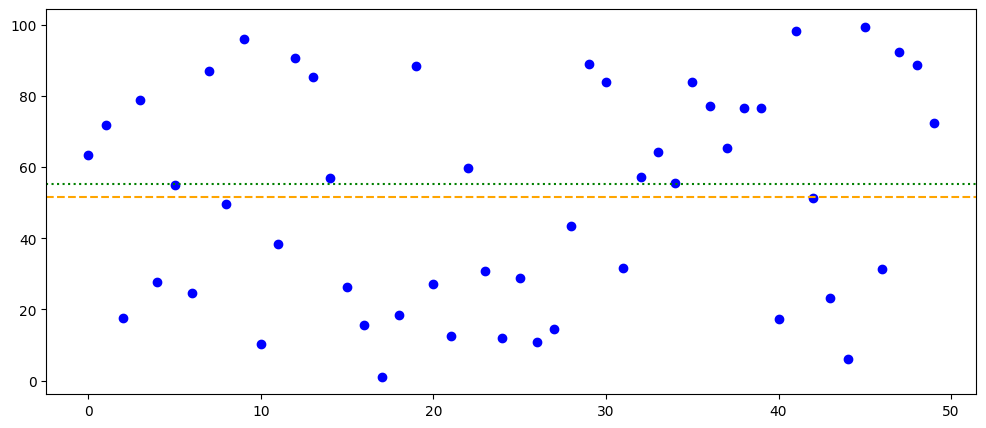

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Voorbeelddata
x = np.random.rand(50) * 100  # 50 willekeurige waarden tussen 0 en 100
m = np.mean(x)  # Gemiddelde
md = np.median(x)  # Mediaan
t20 = ...  # Voeg hier je eigen berekening toe voor de trimmean
wm = ...  # Voeg hier je eigen berekening toe voor de weighted mean
# Visualisatie
plt.figure(figsize=(12, 5))
# Scatterplot met kleur
plt.scatter(range(len(x)), x, color='blue', label="Waarden")  # Kleur voor de scatterplot
# Gemiddelde lijn
plt.axhline(m, linestyle="--", color='orange', label=f"Mean = {m:.2f}")  # Kleur voor gemiddelde
# Mediaan lijn
plt.axhline(md, linestyle=":", color='green', label=f"Median = {md:.2f}")  # Kleur voor mediaan
# Getrimde gemiddelde lijn
plt.axhline(t20, linestyle="-.", color='red', label=f"Trimmed 20% = {t20:.2f}")  # Kleur voor getrimde gemiddelde
# Gewogen gemiddelde lijn
plt.axhline(wm, linestyle=(0, (5, 2)), color='purple', label=f"Weighted = {wm:.2f}")  # Kleur voor gewogen gemiddelde
# Titels en labels
plt.title("Mean vs Median vs Trimmed Mean vs Weighted Mean")
plt.xlabel("Index")
plt.ylabel("Waarde")
plt.legend()
plt.tight_layout()
plt.show()